In [1]:
import pandas as pd
import numpy as np
import os
from utils.utils import PROJECT_DATA_DIR
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import keras
from sklearn.metrics import mean_squared_error
from keras import regularizers
from scipy.ndimage.interpolation import shift


Using TensorFlow backend.


In [2]:
cls = pd.read_csv(os.path.join(PROJECT_DATA_DIR, 'closing_prices_tiingo.csv'))
cls.set_index('date', inplace=True)
op = pd.read_csv(os.path.join(PROJECT_DATA_DIR, 'opening_prices_tiingo.csv'))

In [ ]:
display(cls.head())
print(cls.iloc[0:1, 1].name)

## Preprocessing
Functions to preprocess data

In [4]:
def transform_data(x_train, x_dev, x_test, normalize=False):
    """ Do imputing and scaling in two steps. If done in
    pipeline then it is not possible to inverse-transform.
    No need to inverse transform imputing"""

    imputer = Imputer(strategy='mean')
    x_train = imputer.fit_transform(x_train)
    x_dev = imputer.transform(x_dev)
    x_test = imputer.transform(x_test)

    if normalize:
        scaler = MinMaxScaler(feature_range=(-1, 1))
        train_x = scaler.fit_transform(x_train)
        dev_x = scaler.transform(x_dev)
        test_x = scaler.transform(x_test)
    else:
        train_x = x_train
        dev_x = x_dev
        test_x = x_test
        scaler = None

    return train_x, dev_x, test_x, scaler

In [5]:
def split_train_dev_test(seq, dev=0.85,
                         timesteps=30,
                         normalize=False,
                         to_ret=False,
                         differenced=False):

    x_train, x_dev, x_test, names = get_train_dev_test(seq, dev=dev)
    print('shape of train, dev and test sets:',
          x_train.shape, x_dev.shape, x_test.shape)

    # code added 2018-03-23
    if differenced:
        x_train = x_train.diff()
        x_dev = x_dev.diff()
        x_test = x_test.diff()

    if to_ret:
        x_train = x_train.apply(to_return)
        x_dev = x_dev.apply(to_return)
        x_test = x_test.apply(to_return)

    train_x, dev_x, test_x, scaler = transform_data(x_train,
                                                    x_dev, x_test,
                                                    normalize=normalize)

    train_x = to_tensor(train_x, timesteps=timesteps)
    x_train = train_x[:, :-1, :]
    y_train = train_x[:, -1]

    dev_x = to_tensor(dev_x, timesteps=timesteps)
    x_dev = dev_x[:, :-1, :]
    y_dev = dev_x[:, -1]

    test_x = to_tensor(test_x, timesteps=timesteps)
    x_test = test_x[:, :-1, :]
    y_test = test_x[:, -1]
    print('printing from the split-train-dev-test function:')
    print('y_dev raw data:')
#    print(scaler.inverse_transform(y_dev))

    return x_train, y_train, x_dev, y_dev, x_test, y_test, scaler, names


In [6]:
def to_return(x, period=1):
    """ This function supposes that the input is a
    dataframe"""
    x_shifted = x.shift(periods=period, axis='index')
    return (x - x_shifted)/x_shifted

In [7]:
def to_tensor(data, timesteps=30):
    x = np.array([data[i:i + timesteps]
                  for i in range(len(data) - timesteps)], dtype=float)
    return x

In [8]:
def get_train_dev_test(data_x, dev=0.85, drop_col=0.05):
    """ Split data in
    - training,
    - development
    - test data (also called live data)
    """
    """ We choose to keep the last 10 % of the data
    as test data (live trading, live data). The tests
    are performed when the model is finnished training"""

    # Check if 10% or more are NAs if so drop those stocks
    # inform how many are droped and how many are left.
    dropped_stocks = []
    for col in data_x.columns:
        if data_x[col].isnull().sum()/len(data_x) > drop_col:
            dropped_stocks.append(col)
            data_x = data_x.drop(col, axis=1)
            print('Stock {} has been dropped as it had more than {} % Nas'.\
                  format(col, drop_col * 100))

    print('Number of stocks dropped:', len(dropped_stocks))
    print('Number of stocks that are kept: ', len(data_x.columns))

    test_idx = int(0.9 * len(data_x))
    x_test = data_x.iloc[test_idx:, :]

    """Get the first 90% of the data for train-dev"""
    train_dev_x = data_x.iloc[:test_idx]

    dev_idx = int(dev * len(train_dev_x))
    x_train = train_dev_x.iloc[:dev_idx, :]
    x_dev = train_dev_x.iloc[dev_idx:, :]

    return x_train, x_dev, x_test, data_x.columns

## Functions for plotting

In [19]:
def plot_compare(y_dev, dev_predict):
    k = y_dev.shape[1]
    start = 0
    step = 5
    end = step
    for i in range(0, k, step):
        ax = dev_predict.iloc[:, start:end].plot(
                subplots=True,
                figsize=(15, 20),
                label='Predictions on dev-set', color='DarkBlue')

        y_dev.iloc[:, start:end].plot(ax=ax, subplots=True, figsize=(15, 20),
                  title='Real data together with predictions', label='real data',
                  color='DarkGreen')
        end += i

In [20]:
def plot_error_curves(history):
    f1, axarr1 = plt.subplots(2, 1, sharex=True, figsize=(8, 10))
    axarr1[0].plot(history.history['loss'])
    axarr1[0].set_title('Training Loss')
    axarr1[1].plot(history.history['val_loss'])
    axarr1[1].set_title('Dev Loss')
    axarr1[1].set_xlabel('Epochs')
#    f1.suptitle('MSE for stock: {}'.format(st_name))
    plt.show()

## Deep Learning
* Long Short Term Memory (LSTM)

## Long Short Term Memory (LSTM)

In [9]:
from keras import optimizers
import math
import time
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, BatchNormalization
from keras import optimizers
from sklearn.svm import SVR


## Build a LSTM model with keras. Use Adam optimizer.
### Long Short Term Memory (LSTM)
The LSTM is a gated network with 4 gates controlling the flow of the gradients. In 1997 the LSTM only had 3 gates, the forget gate was implemented much later in the 2000s.

In a LSTM network is a variant of RNN where the units are replaced by LSTM cells. Each cell has the following components:
* An input node
* An input gate
* An internal state with a unit weight recurrent connection
* A forget gate
* An output gate

<img src="images/lstm_cell.png" style="width: 500px;" style="hight: 500px;"/>

The LSTM is described by:
\begin{align}
f_t &= \sigma_g(W_f x_t + U_f h_{t-1} + b_f)\\
i_t &= \sigma_g(W_i x_t + U_i h_{t-1} + b_i)\\
o_t &= \sigma_g(W_o x_t + U_o h_{t-1} + b_o)\\
\tilde{c}_t &= \sigma_c(W_c x_t + U_c h_{t-1} + b_c)\\
c_t &= f_t \odot c_{t-1} + i_t \odot \tilde{c}_t
\end{align}

The parameters in all these components in each cell is learned by gradient descent. The gradients are computed by Back propagation through time (BPTT). The BPTT will not be derived here as it is more involved than regular backpropagation. It is similar to backpropagation with the addition that we also iterate through the time steps in the unrolled LSTM graph.

Layers:
* batch normalization, https://arxiv.org/pdf/1502.03167.pdf
* LSTM layer
* dropout, http://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf

### Dropout
Dropout is a type of regularization which prevents neural networks to overfit. This type of regularization is also inexpensive, especially when it comes to training neural networks. During training, dropout samples from an exponentially number of different thinned networks. At test time the model is an approximation of the average of all the predictions of all thinned networks only that it is a much smaller model with less weights than the networks used during training. If we have a network with $L$ hidden layers, then $l \in \{1, \dots, L\}$ is the index of each layer. If $\mathbf{z}^{(l)}$ is the input to layer $l$ then $\mathbf{y}^{(l)}$ is the output from that layer with $\mathbf{y}^{(0)} = \mathbf{x}$ denoting the input to the network. Let $W^{(l)}$ denote the weights and $\mathbf{b}^{(l)}$ denote the bias, then the network equations are given by:

\begin{align}
z_i^{(l+1)} &= \mathbf{w}_i^{(l+1)}\mathbf{y}^l + b_i^{(l+1)}\\
y_i^{(l+1)} &= f(z_i^{(l+1)}),
\end{align}

where $f$ is an activation function. Dropout is then a factor that randomly gets rid of some of the outputs from each layer by doing the following operation:

\begin{align}
r_j^{(l)} &\sim \text{Bernoulli(p)},\\
\mathbf{Y}^{(l)} &= \mathbf{r}^{(l)} \odot \mathbf{y}^{(l)},\\
z_i^{(l+1)} &= \mathbf{w}_i^{(l+1)}\mathbf{Y} + b_i^{(l+1)}, \\
y_i^{(l+1)} &= f(z_i^{(l+1)})
\end{align}

where $\odot$ denotes element-wise multiplication.


## Build the LSTM model

In [10]:
def build_model(drop_rate, lr, units, decay,
                look_back,
                no_features=1,
                no_outputs=1):
    """ Arguments
    drop_rate -- drop_rate in dropout
    learning_rate -- learning rate
    time_steps -- time steps for the sequence
    units -- number of hidden units or neurons
    decay -- proportion of decay for learning rate
    no_features -- number of features, default 1 for a 1-dim time series
    no_outputs -- number of targets or outputs from the model
    """
    optim = optimizers.Adam(lr=lr,
                            beta_1=0.9,
                            beta_2=0.999,
                            decay=1e-6, 
                            clipnorm=1.0)

    # TODO: how to implement many layers in keras?
    ret_seq = False
    model = Sequential()
    model.add(BatchNormalization(input_shape=(look_back, no_features)))
    model.add(LSTM(units,input_shape=(look_back, no_features),
                   return_sequences=ret_seq,
                   kernel_regularizer=regularizers.l2(0.01),
                   recurrent_regularizer=regularizers.l2(0.01),
                   activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(drop_rate))
    model.add(BatchNormalization())
    model.add(Dense(no_outputs,
                    kernel_regularizer=regularizers.l2(0.01)))
    model.compile(loss='mean_squared_error',
                  optimizer=optim,
                  metrics=['mse'])
    return model

## Function to fit an LSTM
This function returns fitted model as well as history. History object can be used for plotting loss during training for train and test sets.

In [13]:
def train_lstm(X_train, Y_train, X_dev, Y_dev,
               epochs, drop_rate, batch_size, decay,
               look_back, lr, units):

    num_features = X_train.shape[-1]
    num_outputs = Y_train.shape[-1]
    model = build_model(drop_rate,
                        lr,
                        units,
                        decay,
                        look_back,
                        no_features=num_features,
                        no_outputs=num_outputs)

    history = model.fit(X_train,
                        Y_train,
                        epochs,
                        batch_size,
                        verbose=0,
                        validation_data=(X_dev, Y_dev),
                        shuffle=False)
    return model, history

## Hit-ratio

The hit-ratio is defined as:

$HR = \frac{1}{N}\sum_{t=1}^N U_t$


where $N$ is the total number of trading days and $U_t$ is defined as: 

$
U_t =
\begin{cases}
1 & \quad \text{if } R_t\cdot\hat{R}_{t}  > 0 \\
0 & \quad \text{otherwise},
\end{cases}
$

In [14]:
def hit_ratio(p_true, p_pred, move=1, returns=True):
    """ if working with price series use diff otherwise use
    real the args directly, if diff=True then
    the returns are used to compute the hit-ratio"""
    if returns:
        p_true_sh = shift(p_true, move, cval=np.NaN)
        arg_true = p_true/p_true_sh - 1

        p_pred_sh = shift(p_pred, move, cval=np.NaN)
        arg_pred = p_pred/p_pred_sh - 1

    else:
        arg_true = p_true
        arg_pred = p_pred
    P = np.multiply(arg_true, arg_pred)
    result = np.mean(np.where(P > 0, 1, 0))
    return result

## Train function
Function to do training with hyperparameter optimization.

In [16]:
def performance(model, x, y, scaler):
    pred = model.predict(x)
    dim = len(pred.shape)

    if dim < 2:
        pred = pred.reshape(-1, 1)

    pred_reversed = get_inv(pred, scaler)
    ytrue_reversed = get_inv(y, scaler)
    ratio = hit_ratio(ytrue_reversed, pred_reversed)

    return pred_reversed, ytrue_reversed, ratio

In [17]:
def train(x_train, y_train, x_dev, y_dev,
          scaler, patience=2, normalize=True):
    """ Training function, calls train_lstm and optimizes
    hyperparameters"""
    count = 0
    optimal_parameters = {}

    old_hit = 0
    accepted_hit = 0
    accepted_mse = 0
    old_mse = 1e6

    old_mse_train = 1e6
    old_hit_train = 0
    accepted_hit_train = 0
    accepted_mse_train = 0
    """ Maybe good to save for each new better result?"""
    while  (count < patience): # can be made mor robust
        print('')
        print('.' * 50)
        print('While iteration:', count)
        params = {'drop_rate': np.random.uniform(0.1, 0.5),
                  'lr': 10 ** np.random.uniform(-4, -2),
                  'units': np.random.randint(50, 200),
                  'epochs': np.random.randint(200, 450),
                  'decay': 1e-6,
                  'look_back': x_train.shape[1],
                  'batch_size': np.random.choice(
                          np.array([2**5, 2**6, 2**7, 2**8]))}
        print('')
        print(params)
        print('')
        model, history = train_lstm(x_train, y_train, x_dev, y_dev, **params)
        train_predict = model.predict(x_train)
        dev_predict = model.predict(x_dev)

        if np.any(np.isnan(train_predict)) or np.any(np.isinf(train_predict))\
        or np.any(np.isnan(y_train)) or np.any(np.isinf(y_train)):
            print('')
            print('check if predictions for training dataset are too big!')
            print('are there any Nas or inf? Yes')
            print('train_predict =', train_predict)
            print('y_train =', y_train)
        if np.any(np.isnan(dev_predict)) or np.any(np.isinf(dev_predict))\
        or np.any(np.isinf(y_dev)) or np.any(np.isinf(y_dev)):
            print('')
            print('check if predictions for dev dataset are too big!')
            print('are there any Nas or inf? Yes')
            print('dev_predict =', dev_predict)
            print('y_dev =', y_dev)

        mse_dev = mean_squared_error(y_dev, dev_predict)
        mse_train = mean_squared_error(y_train, train_predict)

        if normalize:
            hit_train = hit_ratio(scaler.inverse_transform(y_train),
                                  scaler.inverse_transform(train_predict),
                                  returns=True)
            hit_dev = hit_ratio(scaler.inverse_transform(y_dev),
                                scaler.inverse_transform(dev_predict),
                                returns=True)

        else:
            hit_train = hit_ratio(y_train, train_predict)
            hit_dev = hit_ratio(y_dev, dev_predict)

        # if diff betwenn train mse and dev mse
        # less than one then no so much overfit
        print('mse for train set:', mse_train)
        print('mse for dev set:', mse_dev)
        print('' )
        print('hit-ratio train:', hit_train)
        print('hit-ratio dev:', hit_dev)

        # TODO: add sequence length as hyper parameter
        # and then pop from optimal parameters
        if (np.abs(mse_train - mse_dev) < .4) and (mse_train < 1. and mse_dev < 1.)\
        and (np.abs(hit_dev - hit_train) < 0.2):
            old_hit = hit_dev
            old_mse = mse_dev
            old_hit_train = hit_train
            old_mse_train = mse_train
            # new code 2018-03-27
            # added if cond and put parameter update under condition
            if accepted_hit < old_hit and accepted_mse < old_mse:
                """Swap accepted and old value"""
                accepted_hit, old_hit = old_hit, accepted_hit
                accepted_mse, old_mse = old_mse, accepted_mse
                accepted_mse_train, old_mse_train = old_mse_train, accepted_mse_train
                accepted_hit_train, old_hit_train = old_hit_train, accepted_hit_train
                print('accepted_hit:', accepted_hit)
                optimal_parameters.update(params)
        del model, history
        model, history = None, None
        if len(optimal_parameters) > 0:
            print('')
            print('The optimal parameters found so far', optimal_parameters)
            print('and the results based on optimal parameters are:')
            print('mse_train: {}, hit_train: {}, mse_dev: {}, hit_dev: {}'.format(
                    accepted_mse_train,
                    accepted_hit_train,
                    accepted_mse,
                    accepted_hit))
        else:
            print('')
            print('No optimal parameters found yet')
        del model
        del history
        count += 1
        
    print('')
    print('The optimal parameters are:', optimal_parameters)
    keras.backend.clear_session()
    """ Has to retrain as the model is deleted during the
    while loop"""

    """ It can happen that the model did not find any optimal
    parameters in that case the dict is empty. You should return
    a message that an error happen"""
    try:
        assert len(optimal_parameters) > 0
        model, history = train_lstm(x_train,
                                    y_train,
                                    x_dev,
                                    y_dev,
                                    **optimal_parameters)
        """" Save model to disk in JSON form """
        # Serialize to JSON
        model_json = model.to_json()
        with open('model.json', 'w') as json_file:
            json_file.write(model_json)
        # serialize weights to HDF5
        model.save_weights('model.h5')


        return optimal_parameters, model, history
    except AssertionError:
        print('No optimal parameters were found, try again but train longer.')
        print(' ')

Stock FB has been dropped as it had more than 5.0 % Nas
Stock GOOGL has been dropped as it had more than 5.0 % Nas
Stock GOOG has been dropped as it had more than 5.0 % Nas
Stock V has been dropped as it had more than 5.0 % Nas
Stock PM has been dropped as it had more than 5.0 % Nas
Stock DWDP has been dropped as it had more than 5.0 % Nas
Stock MA has been dropped as it had more than 5.0 % Nas
Stock ABBV has been dropped as it had more than 5.0 % Nas
Stock AVGO has been dropped as it had more than 5.0 % Nas
Number of stocks dropped: 9
Number of stocks that are kept:  40
shape of train, dev and test sets: (3596, 40) (400, 40) (444, 40)
printing from the split-train-dev-test function:
y_dev raw data:

training algorithm:
shape train set: (3566, 29, 40) (3566, 40)
type of train set: <class 'numpy.ndarray'>
shape dev set: (370, 29, 40) (370, 40)
shape test set: (414, 29, 40) (414, 40)

..................................................
While iteration: 0

{'drop_rate': 0.4442698717103797,

C:\Users\gilbe\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


mse for train set: 0.0130477221488
mse for dev set: 0.00835319185136

hit-ratio train: 0.588677790241
hit-ratio dev: 0.583513513514
accepted_hit: 0.583513513514

The optimal parameters found so far {'drop_rate': 0.4442698717103797, 'lr': 0.0002921648409070928, 'units': 164, 'epochs': 433, 'decay': 1e-06, 'look_back': 29, 'batch_size': 256}
and the results based on optimal parameters are:
mse_train: 0.013047722148780704, hit_train: 0.5886777902411666, mse_dev: 0.008353191851357059, hit_dev: 0.5835135135135135

..................................................
While iteration: 1

{'drop_rate': 0.2724332839777559, 'lr': 0.0024383069046159016, 'units': 83, 'epochs': 224, 'decay': 1e-06, 'look_back': 29, 'batch_size': 64}

mse for train set: 0.0145503434653
mse for dev set: 0.00861460412326

hit-ratio train: 0.549418115536
hit-ratio dev: 0.549662162162

The optimal parameters found so far {'drop_rate': 0.4442698717103797, 'lr': 0.0002921648409070928, 'units': 164, 'epochs': 433, 'decay': 1

mse for train set: 0.0141169252233
mse for dev set: 0.00826902560534

hit-ratio train: 0.548527762199
hit-ratio dev: 0.546351351351

The optimal parameters found so far {'drop_rate': 0.45196218010188105, 'lr': 0.00032613638864168967, 'units': 184, 'epochs': 388, 'decay': 1e-06, 'look_back': 29, 'batch_size': 32}
and the results based on optimal parameters are:
mse_train: 0.024160505769742442, hit_train: 0.6164610207515423, mse_dev: 0.011146745573557024, hit_dev: 0.6122297297297298

..................................................
While iteration: 13

{'drop_rate': 0.15690303592960195, 'lr': 0.00028162522995694403, 'units': 174, 'epochs': 200, 'decay': 1e-06, 'look_back': 29, 'batch_size': 128}

mse for train set: 0.0135072223961
mse for dev set: 0.0082630104002

hit-ratio train: 0.594461581604
hit-ratio dev: 0.585067567568

The optimal parameters found so far {'drop_rate': 0.45196218010188105, 'lr': 0.00032613638864168967, 'units': 184, 'epochs': 388, 'decay': 1e-06, 'look_back': 29,

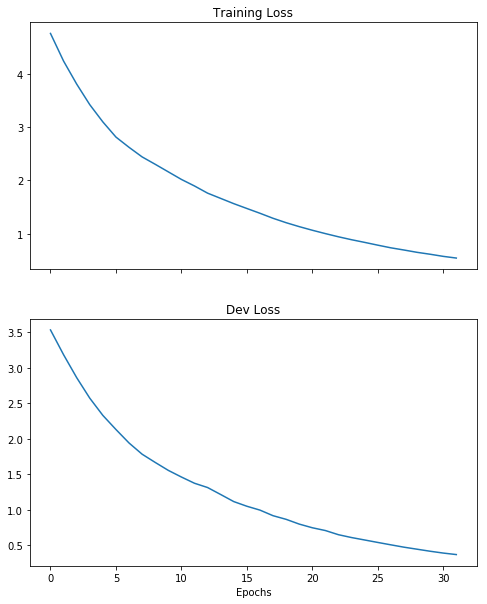

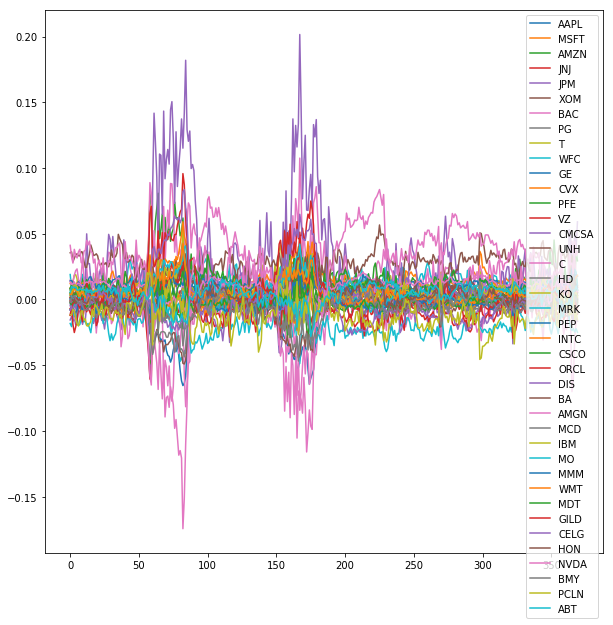

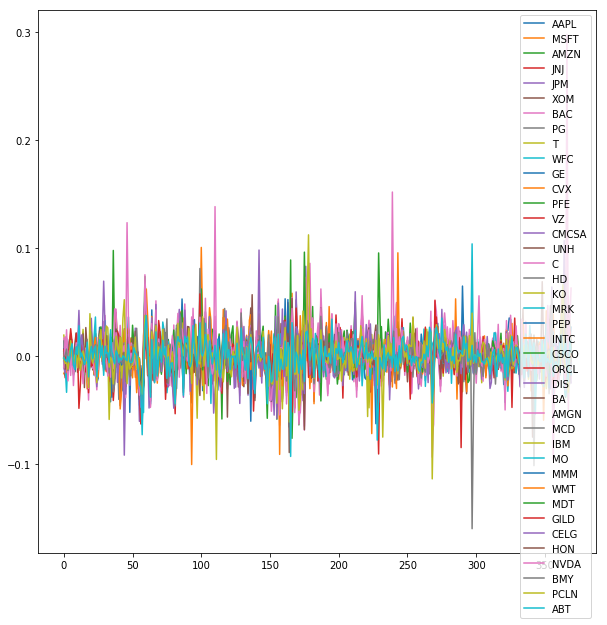

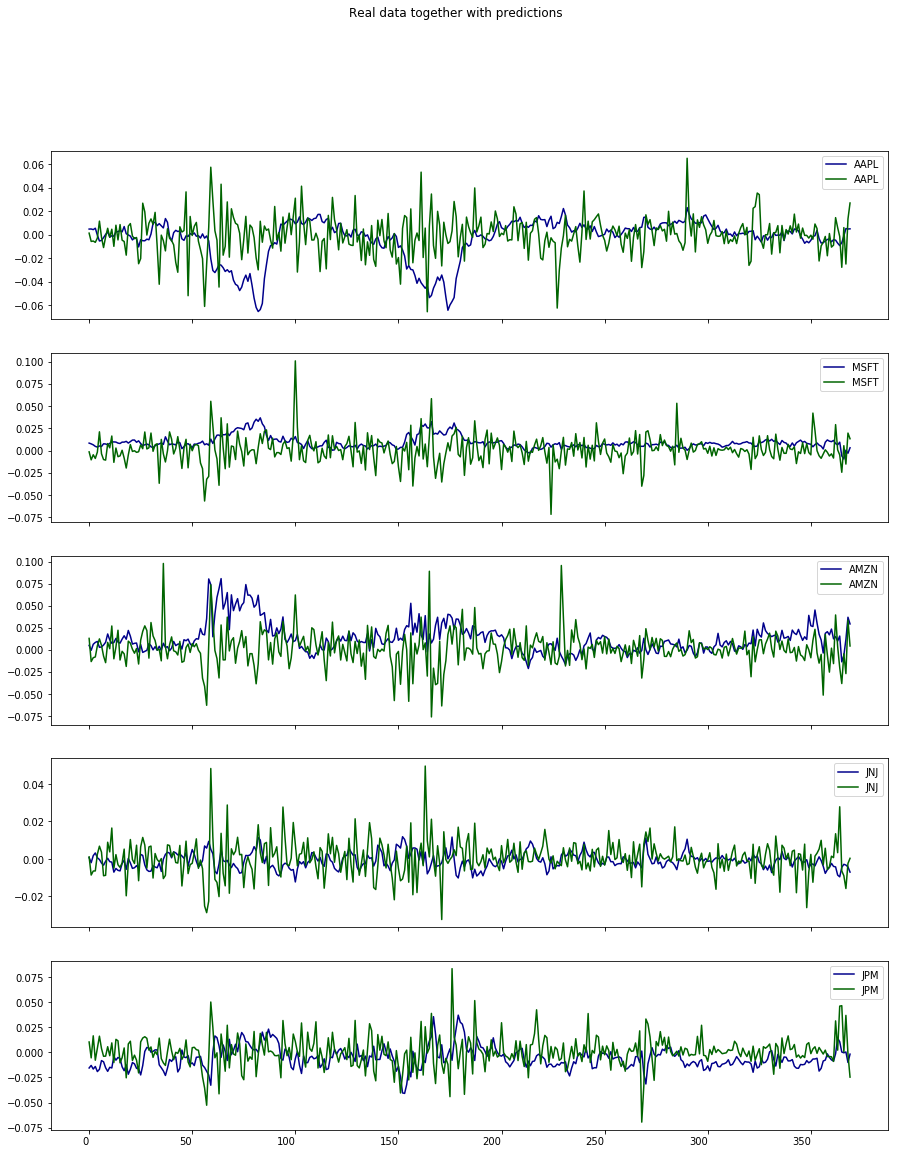

In [18]:
def main():
    count = 1
    NORMALIZE = True
    (x_train, y_train, x_dev, y_dev,
     x_test, y_test, scaler, stock_names) = split_train_dev_test(cls,
                                                                 normalize=NORMALIZE,
                                                                 to_ret=True,
                                                                 dev=0.9,
                                                                 differenced=False)
    print('')
    print('training algorithm:')
    print('shape train set:', x_train.shape, y_train.shape)
    print('type of train set:', type(x_train))
    print('shape dev set:', x_dev.shape, y_dev.shape)
    print('shape test set:', x_test.shape, y_test.shape)

    optimal_parameters, model, history = train(x_train,
                                               y_train,
                                               x_dev,
                                               y_dev,
                                               scaler,
                                               patience=20,
                                               normalize=NORMALIZE)

    """Both targets and predictions have to be transformed"""
    dev_predict = model.predict(x_dev)
    arg_pred_dev = dev_predict
    arg_y_dev = y_dev

    if NORMALIZE:
        arg_pred_dev = scaler.inverse_transform(dev_predict)
        arg_y_dev = scaler.inverse_transform(y_dev)

    dev_predict = pd.DataFrame(arg_pred_dev, columns=stock_names)
    y_dev = pd.DataFrame(arg_y_dev, columns=stock_names)

    plot_error_curves(history)

    dev_predict.plot(figsize=(10, 10))

    dev_predict.iloc[:, 0:5]

    y_dev.plot(figsize=(10, 10))

    ax = dev_predict.iloc[:, 0:5].plot(
            subplots=True,
            figsize=(15, 20),
            label='Predictions on dev-set',
            color='DarkBlue')

    y_dev.iloc[:, 0:5].plot(ax=ax,
              subplots=True,
               figsize=(15, 20),
               title='Real data together with predictions',
               label='real data',
               color='DarkGreen')

if __name__ == '__main__':
    main()
